# Importing Libraries

In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
#%tensorflow_version 1.15.0
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
Found GPU at: /device:GPU:0


In [ ]:
#!pip install gast==0.2.2
#!pip install keras==2.1.6
#!pip install flowpm==0.1

In [4]:
import tensorflow as tf
from tensorflow.contrib.opt import ScipyOptimizerInterface
print(tf.version.VERSION)

#import keras.backend as K

import scipy
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
from scipy import ndimage

import numpy as np

import flowpm
from flowpm.kernels import fftk
from flowpm import linear_field, lpt_init, nbody, cic_paint
import flowpm.tfpm as tfpm
import flowpm.utils as pmutils

%pylab inline

1.15.2
Populating the interactive namespace from numpy and matplotlib


# Global simulation parameters

[0.02 0.05 0.08 0.11 0.14 0.17 0.2  0.23 0.26 0.29 0.32 0.35 0.38 0.41
 0.44 0.47 0.5  0.53 0.56 0.59 0.62 0.65 0.68 0.71 0.74 0.77 0.8  0.83
 0.86 0.89 0.92 0.95 0.98 1.01 1.04 1.07 1.1  1.13 1.16 1.19 1.22 1.25
 1.28 1.31 1.34 1.37 1.4  1.43 1.46 1.49 1.52 1.55 1.58 1.61 1.64 1.67
 1.7  1.73 1.76 1.79 1.82 1.85 1.88 1.91 1.94 1.97 2.   2.03 2.06 2.09
 2.12 2.15 2.18 2.21 2.24 2.27 2.3  2.33 2.36 2.39 2.42 2.45 2.48 2.51
 2.54 2.57 2.6  2.63 2.66 2.69 2.72 2.75 2.78 2.81 2.84 2.87 2.9  2.93
 2.96 2.99 3.02 3.05 3.08 3.11 3.14 3.17 3.2  3.23 3.26 3.29 3.32 3.35
 3.38 3.41 3.44 3.47 3.5  3.53 3.56 3.59 3.62 3.65 3.68 3.71 3.74 3.77
 3.8  3.83 3.86 3.89 3.92 3.95 3.98 4.01 4.04 4.07 4.1  4.13 4.16 4.19
 4.22 4.25 4.28 4.31 4.34 4.37 4.4  4.43 4.46 4.49]


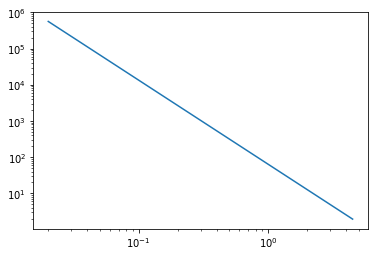

In [5]:
bs = 64 #simulation box size in Mpc/h
nc = 64 #particle number sidelength (i.e. nc**3 is number of particles in sim)

# Test Power spectrum model
def true_test_powerspectrum(k, a, n):
    return a*(k**n)

#change paths
#klin = np.loadtxt('./Planck15_a1p00.txt').T[0]
klin = np.arange(0.02, 4.5, 0.03)
#plin = np.loadtxt('./Planck15_a1p00.txt').T[1]
plin = np.zeros(len(klin))
i=0
for k in klin:
    plin[i] = true_test_powerspectrum(k, 63, -2.3)
    i += 1

# fiducial cosmology function
ipklin = iuspline(klin, plin)

plt.loglog(klin, plin)
print(klin)
#np.random.seed(0)

# Helper Functions
### i) Global power spectra helper functions

In [6]:
def _initialize_pk(shape,boxsize,kmin,dk):
    """
       Helper function to initialize various (fixed) values for powerspectra... not differentiable!
    """
    I = np.eye(len(shape), dtype='int') * -2 + 1

    W = np.empty(shape, dtype='f4')
    W[...] = 2.0
    W[..., 0] = 1.0
    W[..., -1] = 1.0
    kedges = np.arange(kmin, np.pi * 3 / 2 + dk/2, dk)

    k = [np.fft.fftfreq(N, 1. / (N * 2 * np.pi / L))[:pkshape].reshape(kshape) for N, L, kshape, pkshape in zip(shape.as_list(), boxsize, I, shape.as_list())]
    kmag = sum(ki ** 2 for ki in k) ** 0.5

    xsum = np.zeros(len(kedges) + 1)
    Nsum = np.zeros(len(kedges) + 1)

    dig = np.digitize(kmag.flat, kedges)

    #print(dig.size,xsum.size,len((W * kmag).flat))
    xsum.flat += np.bincount(dig, weights=(W * kmag).flat, minlength=xsum.size)
    Nsum.flat += np.bincount(dig, weights=W.flat, minlength=xsum.size)
    dig = tf.convert_to_tensor(dig,dtype=tf.int32)
    Nsum = tf.convert_to_tensor(Nsum,dtype=tf.complex64)
    xsum = tf.convert_to_tensor(np.array(xsum))
    W = tf.convert_to_tensor(np.array(W))
    k = np.array(k)
    kedges = tf.convert_to_tensor(np.array(kedges))
    return dig, Nsum, xsum, W, k, kedges

In [7]:
def pk(field, kmin=5, dk=0.8, shape = False, boxsize= False):   
    """
    Calculate the powerspectra given real space field
    
    Args:
        
        field: real valued field 
        kmin: minimum k-value for binned powerspectra
        dk: differential in each kbin
        shape: shape of field to calculate field (can be strangely shaped?)
        boxsize: length of each boxlength (can be strangly shaped?)
    
    Returns:
        
        kbins: the central value of the bins for plotting
        power: real valued array of power in each bin
        
    """
    #initialze values related to powerspectra
    dig, Nsum, xsum, W, k, kedges = _initialize_pk(shape,boxsize,kmin,dk)
    
    #convert field to complex for fft
    field_complex = tf.dtypes.cast(field,dtype=tf.complex64)

    #fast fourier transform
    fft_image = tf.signal.fft3d(field_complex)
    
    #absolute value of fast fourier transform
    pk = tf.math.real(fft_image*tf.math.conj(fft_image))
    #calculating powerspectra
    Psum = tf.zeros(tf.size(kedges) + 1, dtype=tf.complex64)
    real = tf.reshape(tf.math.real(pk),[-1,])
    imag = tf.reshape(tf.math.imag(pk),[-1,])
    
    Psum  += tf.dtypes.cast(tf.math.bincount(dig, weights=(tf.reshape(W,[-1])  * imag), minlength=tf.size(xsum)),dtype=tf.complex64)*1j
    Psum  += tf.dtypes.cast(tf.math.bincount(dig, weights=(tf.reshape(W,[-1]) * real), minlength=tf.size(xsum)),dtype=tf.complex64)
    #print(W.flatten()  * imag,Psum)

    power = (Psum / Nsum)[1:-1] * boxsize.prod() 
    
    #normalization for powerspectra
    norm = tf.dtypes.cast(tf.reduce_prod(shape),dtype=tf.float32)**2
    
    #find central values of each bin
    kbins = kedges[:-1]+ (kedges[1:] - kedges[:-1])/2
    
    return kbins,tf.dtypes.cast(power,dtype=tf.float32)/norm

In [8]:
def pk_func(inputs):
    nc = inputs.shape[1] #assume equal dimensions right now
    ic = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Starting Point
    pkr = pk(tf.squeeze(ic,0),shape = ic.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=0.3,dk=0.3)#dk=0.4, kmin = 0.001
    with tf.Session() as sess:
        pk_out = sess.run((pkr),{ic: inputs})
    return pk_out

### ii) Defining optimization-related helper functions 

In [9]:
#variable noise... in this case masking the edges and including variable noise over image
a = numpy.arange(64)
numpy.random.shuffle(a)
noise_prop = np.ones((nc,nc,nc))*0.01
inv_sigma = (1/noise_prop)
def likelihood_fn(inputs, b, predictions, inv_sigma = inv_sigma):
    """ Evaluates the data chi-squared function through Fast PM
    """
    _,final_field = pm(predictions[..., 0],b)

    clipped1 = final_field
    clipped2 = inputs[...,0]
    likelihood = tf.reduce_sum((clipped1-clipped2)**2*inv_sigma**2, 
                              axis=[1, 2, 3])
    return likelihood, final_field

def likelihood_fn_lya(inputs, data, inverse_covar):
    #Evaluates the data chi-squared function through Fast PM
    #Clipping very high values which end up dominating the likelihood

    #weighted by number count in bin for poisson errors
    residual = tf.subtract(inputs, data)
    values = tf.multiply(residual, tf.transpose(tf.sparse.sparse_dense_matmul(inverse_covar, residual, adjoint_b=True)))
    return values

def smoothing(field,Rsm,kmesh,nc):
    """ smoothing field in fourier space
    """
    Rsmsq = tf.multiply(Rsm, Rsm)
    smwts = tf.exp(tf.multiply(-kmesh**2, Rsmsq))

    datak = tfpm.r2c3d(field, norm=nc**3)
    datak = tf.multiply(datak, tf.cast(smwts, tf.complex64))
    dataf = tfpm.c2r3d(datak, norm=nc**3)
    return dataf

In [10]:
def pm(lin,b):
    ''' Evolution operator, NOTE: this is using all the tensorflow tensors, need to use a tf.Session() to evaluate them.
    '''
    state = flowpm.lpt_init(lin, a0=0.1)
    final_state = flowpm.nbody(state, stages, nc)
    final_field = flowpm.cic_paint(tf.zeros_like(lin), final_state[0])
    return  final_field, tf.math.exp(-1*(0.20+b[0])*final_field**(b[1]+1.8))#(0.90+0.1*b[0])*final_field + (0.20+0.1*b[1])*final_field**2.0#tf.math.exp(-(0.22+b[0]*0.0001)*final_field**(1.8+b[1]*0.0001))

In [11]:
class TARDIS:
    def __init__(self, isLyaReconstruction = [False, ], prior_v = [0.0,0.0]):
        self.prior_v = prior_v
        self.isLyaReconstruction = isLyaReconstruction
        self.__init__model()
    def __init__model(self):
        self.xx = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Starting Point
        if (self.isLyaReconstruction[0] == False):
            self.yy = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Data
        else:
            self.skewers_fin = self.isLyaReconstruction[1]
            self.yy = tf.placeholder(tf.float32, [self.skewers_fin.shape[0]]) #lya flux

        self.bias = tf.Variable([0.0,0.0], name="variables", trainable=True) #Bias

        self.linearkk = tf.get_variable('linmesh', shape=(1, nc, nc, nc),
                    initializer=tf.random_normal_initializer(mean=1.0, stddev=0.5), trainable=True)
        self.initlin_op = self.linearkk.assign(self.xx, name='initlin_op')

        linear_wc = tfpm.r2c3d(self.linearkk, norm=nc**3, name=None)
        linear_k = tf.multiply(linear_wc, (pkmesh/bs**3)**0.5)
        self.linear = tfpm.c2r3d(linear_k , norm=nc**3, name=None) #*1024*np.sqrt(2) 

        # Compute the likelihood fn
        if (self.isLyaReconstruction[0] == False):
            self.likelihood, self.final_field = likelihood_fn(tf.expand_dims(self.yy, -1), self.bias, tf.expand_dims(self.linear,-1)) 
        else:
            self.inverse_covar = self.isLyaReconstruction[2]
            self.final_field, self. evolved_field_FGPA = pm(self.linear, self.bias)
            # No RSD stuff for now...
            #evolved_field_FGPA = K.exp(-1.0*self.RSD_tau)#fgpa(self.evolved_field,bias_lya)
            #evolved_field_FGPA = np.exp(-b1*sim2**b2)

            # No smoothing for now...
            #evolved_field_FGPA_sm = smoothing(evolved_field_FGPA, Rsm, kmesh, nc)
        
            self.flux_val = flowpm.cic_readout(self.evolved_field_FGPA, np.array(self.skewers_fin,dtype=np.float32).reshape(1,-1,3))
            self.likelihood_lya = likelihood_fn_lya(self.flux_val, self.yy, self.inverse_covar)
            self.likelihood = reduce_sum_det(self.likelihood_lya)
            
        # Compute the prior on field
        prior_1 = tf.cast(tf.square(tf.abs(linear_wc)), tf.float32)#tf.reduce_sum(tf.multiply(priormesh, 1/pkmesh**2))

        # Compute the prior on the parameters
        prior_values = tf.constant(self.prior_v)
        prior_2 = tf.reduce_sum((prior_values-self.bias)**2.0)/(0.01**2) #rough gaussian prior...

        prior_total = tf.reduce_sum(prior_1)+prior_2

        self.logposterior = tf.reduce_mean(self.likelihood) +  tf.reduce_mean(prior_total)

In [12]:
def optimize(T, variable, data, maxiter, starting_point = np.random.randn(1,nc,nc,nc), gtol=1e-12, sigma=1.0, isLyaReconstruction = False):
    opt = ScipyOptimizerInterface(T.logposterior, var_list=variable, method='L-BFGS-B',
                                                    options={'maxiter': maxiter, 'gtol':gtol})
    sess.run(tf.global_variables_initializer())

    batchsize = 1
    # Initialize gradient descent at random point
    sess.run(T.initlin_op, {T.xx: starting_point});
    st = time.time()
    #opt.minimize(sess, {T.yy:data[0:1]})
    if (isLyaReconstruction == False): opt.minimize(sess, {T.yy:data[0:1]})
    else: opt.minimize(sess, {T.yy:data})
    print("Total Time:", time.time()-st)

# Making Initial Density Field...

In [13]:
# Set initial conditions
initial_conditions = flowpm.linear_field(nc, bs, ipklin, batch_size=1)

with tf.Session() as sess:
    linear_true = sess.run((initial_conditions))

In [14]:
stages = np.linspace(0.1, 0.3, 1, endpoint=True) ## 0.3 when using lyman alpha forest
ic = tf.placeholder(tf.float32, [1, nc, nc,nc]) #Starting Point

# Sample particles
state = flowpm.lpt_init(ic, a0=0.1)   

# Evolve particles down to z=0
final_state = flowpm.nbody(state, stages, nc)         

# Retrieve final density field
final_field = flowpm.cic_paint(tf.zeros_like(ic), final_state[0])

# Calculate power spectra for intial density field
pkr_ic = pk(tf.squeeze(ic,0),shape = final_field.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=0.3,dk=0.3)#dk=0.4, kmin = 0.001

# Calculate power spectra for final density field
pkr = pk(tf.squeeze(final_field,0),shape = final_field.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=0.3,dk=0.3)#dk=0.4, kmin = 0.001
        
with tf.Session() as sess:
    sim, pkr_ic0, pkr_out = sess.run((final_field,pkr_ic,pkr),{ic: linear_true})
    #np.save("fiducial_initial_y_5", pkr_ic0[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [15]:
#setting up prior for model
kvec = fftk((nc, nc, nc), symmetric=False)
kmesh = sum((kk / bs * nc)**2 for kk in kvec)**0.5
pkmesh = ipklin(kmesh)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


0.79684067


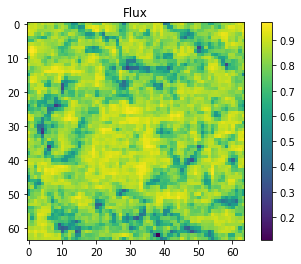

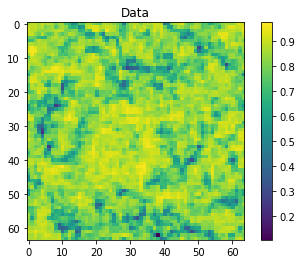

In [16]:
#True Bias Values...
b1=.22
b2=1.8

noise_real = np.random.randn(nc,nc,nc)*noise_prop
sims2 = sim #ndimage.gaussian_filter(sim,0.2,mode="wrap")
gal= np.exp(-b1*sims2**b2)
data = gal + noise_real

print(np.mean(gal))
title("Flux")
imshow(gal[0,4])
colorbar()
show()

title("Data")
imshow(data[0,4])
colorbar()

In [17]:
tf.reset_default_graph()
sess = tf.Session()   
T = TARDIS()
# 1st optimization: Just optimize density field
optimize(T,[T.linearkk], data, maxiter = 500)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1800068.250000
  Number of iterations: 500
  Number of functions evaluations: 522
Total Time: 166.16975355148315


In [18]:
test, inp, fins, bf = sess.run([T.linear,T.linearkk, T.final_field,T.bias], {T.xx:data[0:1],T.yy:data[0:1]})

In [19]:
# 2nd optimizatiton: Optimized Density field + Bias Parameters
optimize(T, [T.linearkk,T.bias], data, starting_point = inp, maxiter = 100)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1157135.125000
  Number of iterations: 12
  Number of functions evaluations: 28
Total Time: 10.802749156951904


In [20]:
test, inp_i, fins, bf = sess.run([T.linear,T.linearkk, T.final_field,T.bias], {T.xx:data[0:1],T.yy:data[0:1]})

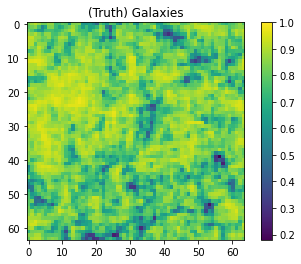

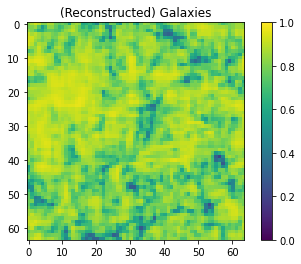

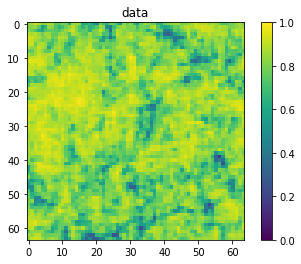

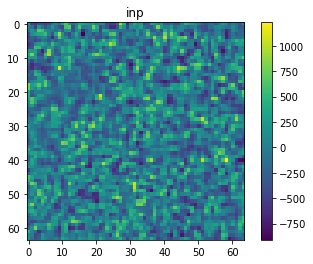

In [21]:
slic = 20

title("(Truth) Galaxies")
imshow(gal[0,slic],vmax=1)
colorbar()
show()

title("(Reconstructed) Galaxies")
imshow((fins[0][slic]),vmin = 0,vmax = 1)
colorbar()
plt.show()

title("data")
imshow(data[0,slic],vmin = 0,vmax = 1)
colorbar()
show()

title("inp")
imshow(inp[0,slic])
colorbar()
show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[0.375 0.525 0.675 0.825 0.975 1.125 1.275 1.425 1.575 1.725 1.875 2.025
 2.175 2.325 2.475 2.625 2.775 2.925 3.075 3.225 3.375 3.525 3.675 3.825
 3.975 4.125 4.275 4.425 4.575]
[5.82602478e+02 2.95040192e+02 1.91009369e+02 1.16415169e+02
 7.82959290e+01 5.66060028e+01 4.15968857e+01 3.14827843e+01
 2.50997257e+01 2.00937748e+01 1.72561283e+01 1.37079840e+01
 1.08549833e+01 7.83876896e+00 5.45746088e+00 3.50219917e+00
 2.22685981e+00 1.39894390e+00 8.38518679e-01 4.63283569e-01
 2.61912555e-01 1.44987538e-01 8.52846801e-02 4.97704521e-02
 3.02524772e-02 1.93076953e-02 1.19711645e-02 7.14713801e-03
 4.42649378e-03]
[ 0.02092198 -0.0749329 ]


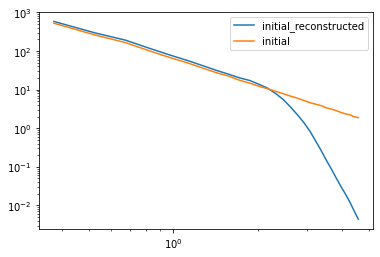

In [22]:
# Calculate and plot true and initial power spectra
reconstructed_pk = pk_func(test)
plt.loglog(reconstructed_pk[0], reconstructed_pk[1], label = 'initial_reconstructed')
plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')
legend()
print(reconstructed_pk[0])
print(reconstructed_pk[1])
print(bf)

In [23]:
def test_powerspectrum(k, a, n):
    return a*(k**n)

test_powerspectrum_x = np.zeros(len(pkr_ic0[0]))
for i in range(len(pkr_ic0[0])):
    test_powerspectrum_x[i] = pkr_ic0[0][i]

test_powerspectrum_y = np.zeros(len(pkr_ic0[1]))
for i in range(len(pkr_ic0[1])):
    test_powerspectrum_y[i] = test_powerspectrum(test_powerspectrum_x[i], 63, -2.3)
    
print(test_powerspectrum_x)
print(test_powerspectrum_y)

[0.375 0.525 0.675 0.825 0.975 1.125 1.275 1.425 1.575 1.725 1.875 2.025
 2.175 2.325 2.475 2.625 2.775 2.925 3.075 3.225 3.375 3.525 3.675 3.825
 3.975 4.125 4.275 4.425 4.575]
[601.26875142 277.31550468 155.57573876  98.06103388  66.77746576
  48.04959681  36.03023747  27.89756907  22.16130168  17.97734781
  14.84012721  12.43262934  10.54834313   9.04831576   7.83641779
   6.84452228   6.02331642   5.33643283   4.75660155   4.26306737
   3.83981996   3.47435803   3.15681157   2.87930876   2.63551288
   2.42027914   2.22939732   2.05939672   1.90739668]


[0.375 0.525 0.675 0.825 0.975 1.125 1.275 1.425 1.575 1.725 1.875 2.025
 2.175 2.325 2.475 2.625 2.775 2.925 3.075 3.225 3.375 3.525 3.675 3.825
 3.975 4.125 4.275 4.425 4.575]


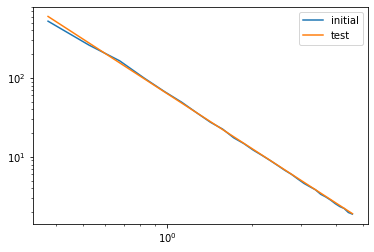

In [24]:
#plt.loglog(reconstructed_pk[0], reconstructed_pk[1], label = 'initial_reconstructed')
plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')
plt.loglog(test_powerspectrum_x, test_powerspectrum_y, label = 'test')
legend()

#np.save("test_powerspectrum_x", test_powerspectrum_x)
#np.save("test_powerspectrum_y", test_powerspectrum_y)
print(pkr_ic0[0])

# Lyman-α skewer reconstruction

### Helper functions

In [25]:
def gen_noise(nzpix, n_skewers, snr_min, snr_max, alpha):
    #generates noise according to specified distribution
    snr = numpy.minimum(snr_min/numpy.random.power(alpha-1,size=n_skewers),snr_max)
    skewers_noise = (1.0/snr[:,numpy.newaxis])*numpy.ones(nzpix)
    return snr, skewers_noise

def likelihood_fn_lya(inputs, data, inverse_covar):
    #Evaluates the data chi-squared function through Fast PM
    #Clipping very high values which end up dominating the likelihood

    #weighted by number count in bin for poisson errors
    residual = tf.subtract(inputs, data)
    values = tf.multiply(residual, tf.transpose(tf.sparse.sparse_dense_matmul(inverse_covar, residual, adjoint_b=True)))
    return values

def reduce_sum_det(x):
    #deterministic reduce sum
    v = tf.reshape(x, [1, -1])
    return tf.reshape(tf.matmul(v, tf.ones_like(v), transpose_b=True), [])

### Create Lyman-α skewer sample

In [26]:
# skewer properties
n_skewers = 4000 #test w 4000
snr_min = 2 #2
snr_max = 10 #10
alpha = 2.8
sm = 0.5

#power law distribution of noise with high snr cutoff
snr, noise_level = gen_noise(nc, n_skewers, snr_min, snr_max, alpha)

In [27]:
# Select skewers
x = np.array(np.floor(np.random.rand(n_skewers)*nc),dtype=int)
y = np.array(np.floor(np.random.rand(n_skewers)*nc),dtype=int)
z = np.arange(0, nc)
        
pos = np.vstack([x,y])
skewers_pos = []
for i in pos.T:
    skewers_pos.append(np.hstack([i*np.ones((nc,2)),z.reshape(1,-1).T]))
    
#final skewer data positions
skewers_fin = np.array(np.vstack(skewers_pos),dtype=int)
        
#flux values at each point 
#### Should be RSD (not sim)
vals_lya = gal[0, skewers_fin[:,0], skewers_fin[:,1], skewers_fin[:,2]]

#add noise
n = numpy.array([numpy.random.normal(scale = np.sqrt(abs(i)), size = nc) for i in noise_level]).flatten()

noise_variance = numpy.array([abs(i)*numpy.ones(nc) for i in noise_level]).flatten()
# The inverse covar must be of type float32.
noise_variance = noise_variance.astype(np.float32)
indices = [(i, i) for i in range(len(noise_variance))]
inverse_covar = tf.SparseTensorValue(indices, noise_variance**-1, [len(noise_variance), len(noise_variance)])
       
vals_observed = ndimage.gaussian_filter1d(vals_lya, sm) + n

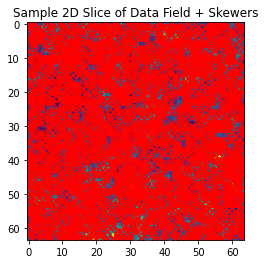

In [28]:
# Plot sample skewers
title("Sample 2D Slice of Data Field + Skewers")
imshow(sim[0,20,:,:])
plot(skewers_fin[::20][:,0],skewers_fin[::20][:,1],"rx")
show()

(array([1865.,  763.,  441.,  220.,  150.,  106.,   96.,   68.,   38.,
         253.]),
 array([ 2.00007454,  2.80006708,  3.60005963,  4.40005218,  5.20004472,
         6.00003727,  6.80002982,  7.60002236,  8.40001491,  9.20000745,
        10.        ]),
 <a list of 10 Patch objects>)

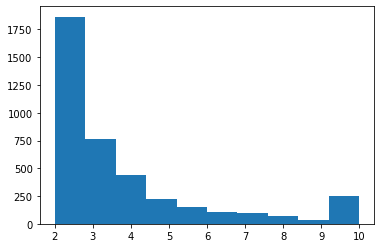

In [29]:
# Plot SNR distribution of skewers
plt.hist(1/noise_level[:,0])

### Running the reconstruction

In [ ]:
tf.reset_default_graph()
sess = tf.Session()   
T = TARDIS(isLyaReconstruction = [True, skewers_fin, inverse_covar])

# LOOP 1: Just optimize density field
optimize(T,[T.linearkk], vals_observed, maxiter = 1000, isLyaReconstruction = True)

In [ ]:
test_lya, inp_lya, fins_lya, bf_lya = sess.run([T.linear,T.linearkk, T.final_field,T.bias], {T.xx:data[0:1],T.yy:vals_observed})

In [ ]:
# LOOP 2: Optimized Density field + Bias Parameters
optimize(T, [T.linearkk,T.bias], vals_observed, starting_point = inp_lya, maxiter = 1000, isLyaReconstruction = True)

In [ ]:
test_lya, inp_i_lya, fins_lya, bf_lya = sess.run([T.linear,T.linearkk, T.final_field,T.bias], {T.xx:data[0:1],T.yy:vals_observed})

In [ ]:
print(bf_lya)

In [ ]:
slic = 20

title("(Truth) Galaxies")
imshow(gal[0,slic],vmax=1)
colorbar()
show()

title("(Reconstructed) Galaxies")
imshow(np.exp(-b1*fins_lya**b2)[0][slic], vmax = 1)
#imshow((fins[0][0,slic]),vmin = 0,vmax = 1)
colorbar()
plt.show()

title("data")
imshow(data[0,slic],vmin = 0,vmax = 1)
colorbar()
show()

title("inp")
imshow(inp_lya[0,slic])
colorbar()
show()

In [ ]:
reconstructed_pk = pk_func(test_lya)
plt.loglog(reconstructed_pk[0], reconstructed_pk[1], label = 'initial_reconstructed')
plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')
legend()
print(reconstructed_pk[1])
#np.save("fiducial_reconstructed_5", reconstructed_pk[1])

In [ ]:
#test_initial_x = np.load("test_powerspectrum_x.npy")
#test_initial_y = np.load("test_powerspectrum_y.npy")
#test_initial_x = np.load("test_initial_pkr_ic0_x.npy")
#test_initial_y = np.load("test_initial_pkr_ic0_y.npy")
#test_initial_reconstructed_x = np.load("test_initial_reconstructed_x.npy")
#test_initial_reconstructed_y = np.load("test_initial_reconstructed_y.npy")

#plt.rcParams["figure.figsize"] = (8,5)
#plt.loglog(reconstructed_pk[0], reconstructed_pk[1], label = 'fiducial_initial_reconstructed')
#plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'fiducial_initial')
#plt.loglog(test_initial_reconstructed_x, test_initial_reconstructed_y, label = 'test_initial_reconstructed')
#plt.loglog(test_initial_x, test_initial_y, label = 'test_initial')
#legend()

In [ ]:
plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'fiducial_initial')
plt.loglog(test_powerspectrum_x, test_powerspectrum_y, label = 'test_initial')
legend()

In [ ]:
#plt.loglog(reconstructed_pk[0], reconstructed_pk[1], label = 'fiducial_initial_reconstructed')
#plt.loglog(test_initial_reconstructed_x, test_initial_reconstructed_y, label = 'test_initial_reconstructed')
#legend()

In [ ]:
#plt.loglog(reconstructed_pk[0], (reconstructed_pk[1]/pkr_ic0[1]), label = 'reconstructed/true (fiducial)')
#plt.loglog(test_initial_reconstructed_x, test_initial_reconstructed_y/test_initial_y, label = 'reconstructed/true (test)')
#legend()

#print(pkr_ic0)

In [ ]:
#fid_recon_y1 = np.load("fiducial_reconstructed_1.npy")
#fid_recon_y2 = np.load("fiducial_reconstructed_2.npy")
#fid_recon_y3 = np.load("fiducial_reconstructed_3.npy")
#fid_recon_y4 = np.load("fiducial_reconstructed_4.npy")
#fid_recon_y5 = np.load("fiducial_reconstructed_5.npy")

#plt.loglog(reconstructed_pk[0], (fid_recon_y1 + fid_recon_y2 + fid_recon_y3 + fid_recon_y4 + fid_recon_y5)/(5*pkr_ic0[1]), label = 'reconstructed/true (fiducial)')
#plt.loglog(test_initial_reconstructed_x, test_initial_reconstructed_y/test_initial_y, label = 'reconstructed/true (test)')
#legend()

# Injecting power

### Helper functions

In [ ]:
def evolve_injected(ic,smwts):
    ic = tf.placeholder(tf.float32, [1, nc, nc,nc]) #Starting Point

    datak = tfpm.r2c3d(ic, norm=nc**3)
    datak = tf.multiply(datak, tf.cast(smwts, tf.complex64))
    dataf = tfpm.c2r3d(datak, norm=nc**3)

    # Sample particles
    state = flowpm.lpt_init(dataf, a0=0.1)   

    # Evolve particles down to z=0
    final_state = flowpm.nbody(state, stages, nc)         

    # Retrieve final density field
    final_field = flowpm.cic_paint(tf.zeros_like(dataf), final_state[0])
    pkr_ic = pk(tf.squeeze(dataf,0),shape = final_field.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=0.3,dk=0.3) #0.001, 0.05

    pkr = pk(tf.squeeze(final_field,0),shape = final_field.shape[1:],  boxsize= np.array([bs,bs,bs]),kmin=0.3,dk=0.3) #0.05
        
    with tf.Session() as sess:
        sim_mode, pkr_ic_mode, pkr_out_mode = sess.run((final_field,pkr_ic,pkr),{ic: linear_true})
    return sim_mode, pkr_ic_mode, pkr_out_mode

### Rerunning the reconstructions

In [ ]:
delta = 0.06 #0.06
modes = np.linspace(pkr_ic0[0], max(pkr_ic0[0]), reconstructed_pk[0].size)#0.01
print(modes)

[0.45 0.75 1.05 1.35 1.65 1.95 2.25 2.55 2.85 3.15 3.45 3.75 4.05 4.35
 4.65]


In [ ]:
N = modes.size
print(N)
filts = np.empty(shape=(N,), dtype=object)

for i in range(0, N, 1):
    filts[i] = np.logical_and(kmesh<modes[i]+delta,kmesh>modes[i]-delta)*2 + 1

fisher_matrix = np.zeros((N, N))

15


In [ ]:
reconstructed_extra_power_fields= np.empty(shape=(N,), dtype=object)
true_extra_power_fields = np.empty(shape=(N,), dtype=object)
true_initial_mode_pks = np.empty(shape=(N,), dtype=object)
reconstructed_initial_mode_pks = np.empty(shape=(N,), dtype=object)
reconstructed_bf = np.empty(shape=(N,), dtype=object)

In [ ]:
for i in range(0, N, 1):
    print("N=",i)
    st = time.time()  
    tf.reset_default_graph()
    #----------------------------------------------------------
    
    smwts = filts[i]
    #apply transfer function to intial conditions
    sim_mode, pkr_ic_mode, pkr_out_mode = evolve_injected(ic,smwts)
    true_extra_power_fields[i] = linear_true
    true_initial_mode_pks[i] = pkr_ic_mode
    
    sims2_mode = sim_mode
    gal_mode= np.exp(-1*b1*sims2_mode**b2)
    
    #flux values at each point 
    #### Should be RSD (not sim)
    vals_lya_mode = gal_mode[0, skewers_fin[:,0], skewers_fin[:,1], skewers_fin[:,2]]

    #add noise
    n = numpy.array([numpy.random.normal(scale = np.sqrt(abs(i)), size = nc) for i in noise_level]).flatten()       
    vals_observed = ndimage.gaussian_filter1d(vals_lya_mode, sm) + n
    #----------------------------------------------------------
    
    sess = tf.Session()   
    T = TARDIS(isLyaReconstruction = [True, skewers_fin, inverse_covar])

    # LOOP 1: Just optimize density field
    optimize(T,[T.linearkk], vals_observed, maxiter = 1000, isLyaReconstruction = True)
    test_lya_mode, inp_lya_mode, fins_lya_mode, bf_lya_mode = sess.run([T.linear,T.linearkk, T.final_field,T.bias], {T.xx:data[0:1],T.yy:vals_observed})
    
    # LOOP 2: Optimized Density field + Bias Parameters (TEST COMMENTED OUT)
    optimize(T, [T.linearkk,T.bias], vals_observed, starting_point = inp_lya_mode, maxiter = 1000, isLyaReconstruction = True)
    test_lya_mode, inp_i_lya_mode, fins_lya_mode, bf_lya_mode = sess.run([T.linear,T.linearkk, T.final_field,T.bias], {T.xx:data[0:1],T.yy:vals_observed})
    #----------------------------------------------------------
    
    # Calculate and save reconstructed power spectra
    reconstructed_pk_mode = pk_func(test_lya_mode)
    reconstructed_initial_mode_pks[i] = reconstructed_pk_mode
    reconstructed_bf[i] = bf_lya_mode
    
    print(i,time.time()-st)
    
#np.save('initial_reconstructed_w_extra_power_pks_lya', reconstructed_initial_mode_pks)
#np.save('initial_true_w_extra_power_pks_lya', true_initial_mode_pks)
#np.save('linear_reconstructed_w_extra_power_fields_lya', reconstructed_extra_power_fields)
#np.save('linear_true_w_extra_power_fields_lya', true_extra_power_fields)

N= 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 256807.546875
  Number of iterations: 432
  Number of functions evaluations: 445
Total Time: 155.67532396316528
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 254337.718750
  Number of iterations: 10
  Number of functions evaluations: 25
Total Time: 11.031179428100586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0 175.36305952072144
N= 1
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 258139.656250
  Number of iterations: 486
  Number of functions evaluations: 504
Total Time: 174.87023782730103
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 255161.375000
  Number of iterations: 10
  Number of functions evaluations: 24
Total Time: 10.838001728057861


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


1 194.34795093536377
N= 2
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 258682.609375
  Number of iterations: 441
  Number of functions evaluations: 476
Total Time: 164.8443522453308
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 255932.859375
  Number of iterations: 11
  Number of functions evaluations: 28
Total Time: 12.01913070678711


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


2 185.28987574577332
N= 3
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 257472.843750
  Number of iterations: 422
  Number of functions evaluations: 447
Total Time: 155.7261939048767
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 254795.109375
  Number of iterations: 12
  Number of functions evaluations: 20
Total Time: 9.568071365356445


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


3 173.99999260902405
N= 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 256309.828125
  Number of iterations: 463
  Number of functions evaluations: 485
Total Time: 167.93884301185608
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 253824.250000
  Number of iterations: 9
  Number of functions evaluations: 24
Total Time: 10.753363609313965


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


4 187.415949344635
N= 5
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 256835.296875
  Number of iterations: 426
  Number of functions evaluations: 445
Total Time: 154.74396634101868
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 254351.109375
  Number of iterations: 10
  Number of functions evaluations: 26
Total Time: 11.430955171585083


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


5 174.86286616325378
N= 6
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 255692.890625
  Number of iterations: 408
  Number of functions evaluations: 427
Total Time: 148.74252653121948
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 253247.703125
  Number of iterations: 10
  Number of functions evaluations: 46
Total Time: 17.439873933792114


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


6 174.65386605262756
N= 7
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 256276.828125
  Number of iterations: 556
  Number of functions evaluations: 578
Total Time: 200.79601335525513
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 253869.296875
  Number of iterations: 10
  Number of functions evaluations: 25
Total Time: 11.00117015838623


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


7 220.39209699630737
N= 8
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 256675.031250
  Number of iterations: 457
  Number of functions evaluations: 481
Total Time: 167.87908840179443
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 254236.046875
  Number of iterations: 9
  Number of functions evaluations: 28
Total Time: 11.855331659317017


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


8 188.49861216545105
N= 9
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 254863.812500
  Number of iterations: 490
  Number of functions evaluations: 508
Total Time: 176.65401124954224
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 252513.656250
  Number of iterations: 9
  Number of functions evaluations: 18
Total Time: 8.769975900650024


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


9 193.874089717865
N= 10
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 255855.234375
  Number of iterations: 527
  Number of functions evaluations: 549
Total Time: 190.81141138076782
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 253410.187500
  Number of iterations: 10
  Number of functions evaluations: 23
Total Time: 10.367164373397827


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


10 209.8016083240509
N= 11
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 254258.750000
  Number of iterations: 433
  Number of functions evaluations: 447
Total Time: 155.00000524520874
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 251916.265625
  Number of iterations: 10
  Number of functions evaluations: 20
Total Time: 9.448766946792603


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


11 173.21915221214294
N= 12
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 255940.281250
  Number of iterations: 525
  Number of functions evaluations: 545
Total Time: 189.56770205497742
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 253581.250000
  Number of iterations: 9
  Number of functions evaluations: 20
Total Time: 9.51714038848877


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


12 207.51270723342896
N= 13
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 254463.562500
  Number of iterations: 449
  Number of functions evaluations: 471
Total Time: 163.22631525993347
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 252014.078125
  Number of iterations: 10
  Number of functions evaluations: 22
Total Time: 10.053492784500122


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


13 181.93334317207336
N= 14
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 255022.890625
  Number of iterations: 520
  Number of functions evaluations: 561
Total Time: 193.4257092475891
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 252645.500000
  Number of iterations: 9
  Number of functions evaluations: 25
Total Time: 10.88353157043457


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


14 213.03594779968262


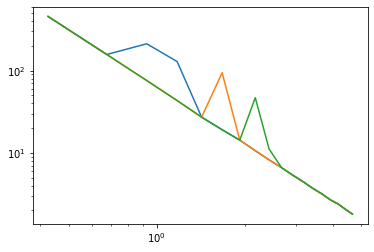

In [ ]:
# sample of 3 input modes, should look like 3 little bumps
# plotting true_initial_mode_pks[i]:
plt.loglog(true_initial_mode_pks[2][0],true_initial_mode_pks[2][1])
plt.loglog(true_initial_mode_pks[4][0],true_initial_mode_pks[4][1])
plt.loglog(true_initial_mode_pks[6][0],true_initial_mode_pks[6][1])

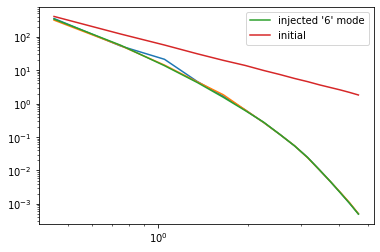

In [ ]:
# Plotting the 3 respective reconstructed power spectra
plt.loglog(reconstructed_initial_mode_pks[2][0],reconstructed_initial_mode_pks[2][1])
plt.loglog(reconstructed_initial_mode_pks[4][0],reconstructed_initial_mode_pks[4][1])
plt.loglog(reconstructed_initial_mode_pks[6][0],reconstructed_initial_mode_pks[6][1], label = 'injected \'6\' mode')
plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')
plt.legend()

In [ ]:
#calculating average reconstructed PS to reduce noise... could also just run the first part of the code a few dozen times...
pks = [reconstructed_initial_mode_pks[n][1] for n in range(0,N,3)]
pk_c = np.median(np.array(pks),axis = 0)

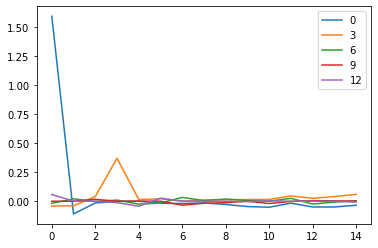

In [ ]:
#response of little bumps
for i in range(0,N,3):
    plot(np.array(reconstructed_initial_mode_pks[i][1]-pk_c)[0:]/pk_c[0:],label=str(i))
legend()
#ylim(-5,5)

In [ ]:
print(reconstructed_bf[1])

[0. 0.]


In [ ]:
tf.reset_default_graph()
# Add variation to Bias Values
b1_new= b1+delta

# calculating b1 variation response
noise_real = np.random.randn(nc,nc,nc)*noise_prop#np.random.randn(1,32,32,32)*2
sims2_new = sim#ndimage.gaussian_filter(sim,0.2,mode="wrap")
new_gal= np.exp(-b1_new*sims2_new**b2)
new_data = new_gal + noise_real

#flux values at each point 
#### Should be RSD (not sim)
new_vals_lya = new_gal[0, skewers_fin[:,0], skewers_fin[:,1], skewers_fin[:,2]]

#add noise
n = numpy.array([numpy.random.normal(scale = np.sqrt(abs(i)), size = nc) for i in noise_level]).flatten()       
new_vals_observed = ndimage.gaussian_filter1d(new_vals_lya, sm) + n

######## LOOP 1: Just optimize density field
sess = tf.Session()   
T = TARDIS(isLyaReconstruction = [True, skewers_fin, inverse_covar])
optimize(T,[T.linearkk],new_vals_observed,starting_point =inp, maxiter = 1000, isLyaReconstruction = True)

#test, inp_i, fins, bf 
test_1, inp_1, fins_1, bff_1 = sess.run([T.linear,T.linearkk, T.final_field,T.bias], {T.xx:data[0:1],T.yy:new_vals_observed})    
print(bff_1)

###### LOOP 2: Optimized Density field + Bias Parameters

optimize(T,[T.linearkk,T.bias],new_vals_observed,starting_point =inp_1, maxiter = 1000, isLyaReconstruction = True)

inp_1, test_1, fins_1, bff_1= sess.run([T.linearkk,T.linear, T.final_field,T.bias], {T.xx:data[0:1],T.yy:new_vals_observed})    

print(bff_1)
#########

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 259194.343750
  Number of iterations: 554
  Number of functions evaluations: 577
Total Time: 203.5393488407135
[0. 0.]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 252980.234375
  Number of iterations: 11
  Number of functions evaluations: 29
Total Time: 12.39032244682312
[0.07732224 0.22688982]


In [ ]:
tf.reset_default_graph()

b2_new= b2+delta

# calculating b1 variation response
noise_real = np.random.randn(nc,nc,nc)*noise_prop#np.random.randn(1,32,32,32)*2
sims2_new = sim#ndimage.gaussian_filter(sim,0.2,mode="wrap")
new_gal= np.exp(-b1*sims2_new**b2_new)
new_data = new_gal + noise_real


#flux values at each point 
#### Should be RSD (not sim)
new_vals_lya = new_gal[0, skewers_fin[:,0], skewers_fin[:,1], skewers_fin[:,2]]

#add noise
n = numpy.array([numpy.random.normal(scale = np.sqrt(abs(i)), size = nc) for i in noise_level]).flatten()       
new_vals_observed = ndimage.gaussian_filter1d(new_vals_lya, sm) + n

######## LOOP 1: Just optimize density field

sess = tf.Session()   
T = TARDIS(isLyaReconstruction = [True, skewers_fin, inverse_covar])
optimize(T,[T.linearkk],new_vals_observed,starting_point =inp, maxiter = 1000, isLyaReconstruction = True)

#test, inp_i, fins, bf 
test_2, inp_2, fins_2, bff_2 = sess.run([T.linear,T.linearkk, T.final_field,T.bias], {T.xx:new_data[0:1],T.yy:new_vals_observed})    
print(bff_2)

####### LOOP 2: Optimized Density field + Bias Parameters

optimize(T,[T.linearkk,T.bias],new_vals_observed,starting_point =inp_1, maxiter = 1000, isLyaReconstruction = True)

inp_2, test_2, fins_2, bff_2= sess.run([T.linearkk,T.linear, T.final_field,T.bias], {T.xx:data[0:1],T.yy:new_vals_observed})    

print(bff_2)

#########

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 256020.921875
  Number of iterations: 543
  Number of functions evaluations: 556
Total Time: 195.74879050254822
[0. 0.]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 270881.562500
  Number of iterations: 8
  Number of functions evaluations: 19
Total Time: 9.304296255111694
[ 0.0074927  -0.05916478]


In [ ]:
reconstructed_bft = np.array([i for i in reconstructed_bf[:]])
bl = [reconstructed_bft[:,0].mean(),reconstructed_bft[:,1].mean()]

In [ ]:
bff_1,bff_2

(array([0.07732224, 0.22688982], dtype=float32),
 array([ 0.0074927 , -0.05916478], dtype=float32))

In [ ]:
bl = [reconstructed_bft[:,0].mean(),reconstructed_bft[:,1].mean()]

In [ ]:
(bff_1 - bl)/delta, (bff_2 - bl)/delta

(array([1.288704, 3.781497], dtype=float32),
 array([ 0.12487829, -0.9860797 ], dtype=float32))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-

[4.26981293e+02 6.69168320e+01 1.56426449e+01 4.79029942e+00
 1.71802950e+00 6.97450340e-01 2.84244299e-01 1.22915894e-01
 5.55099510e-02 2.51385681e-02 1.05987648e-02 4.66715544e-03
 2.21459800e-03 1.03634398e-03 4.99191112e-04]


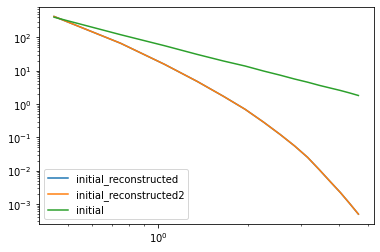

In [ ]:
reconstructed_pk = pk_func(test_1)
plt.loglog(reconstructed_pk[0], reconstructed_pk[1], label = 'initial_reconstructed')
reconstructed_pk_ii = pk_func(test_2)
plt.loglog(reconstructed_pk_ii[0], reconstructed_pk_ii[1], label = 'initial_reconstructed2')
plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')
legend()
print(reconstructed_pk[1])

[]

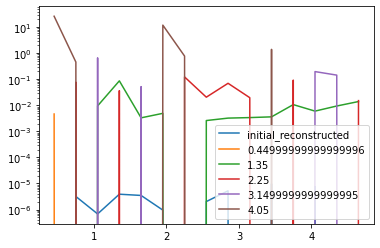

In [ ]:
#response of little bumps
plt.plot(reconstructed_pk[0], np.array(reconstructed_pk[1]-reconstructed_pk_ii[1])[0:]/reconstructed_pk_ii[1]/delta/3, label = 'initial_reconstructed')

for i in range(0,N,3):
    plot(reconstructed_pk[0],np.array(reconstructed_initial_mode_pks[i][1]-pk_c)[0:]/pk_c[0:]/pk_c[i],label=str(reconstructed_pk[0][i]))
legend()

semilogy()

In [ ]:
np.array(reconstructed_pk[1]-reconstructed_pk_ii[1])[0:]/reconstructed_pk_ii[1]/delta

array([ 0.0000000e+00,  9.5010964e-06,  2.0322104e-06,  1.1613270e-05,
        1.0408090e-05,  2.8486932e-06, -2.4464396e-05,  6.0615298e-06,
        1.5659089e-05, -2.4698370e-06,  2.9290339e-05, -2.9932180e-05,
        2.2779173e-05,  0.0000000e+00, -1.3603784e-05], dtype=float32)

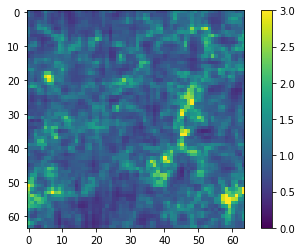

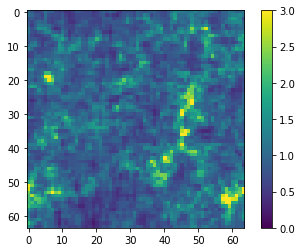

In [ ]:
imshow(np.exp((np.log(-1*np.log(fins)/b1)/b2))[0,0],vmax=3,vmin=0)
colorbar()
show()
imshow(sim[0,0],vmax=3,vmin=0)
colorbar()


In [ ]:
reconstructed_pk_1 = pk_func(test_1)
reconstructed_pk_2 = pk_func(test_2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# Calculating the Fisher Matrix

In [ ]:
pks = [reconstructed_initial_mode_pks[n][1] for n in range(0,N,3)]
pk_c = np.median(np.array(pks),axis = 0)

np.save("fid_pks", pks)
np.save("fid_pk_c", pk_c)
np.save("fid_pkr_ic0_x", pkr_ic0[0])
np.save("fid_pkr_ic0_y", pkr_ic0[1])

np.save("fid_reconstructed_initial_mode_pks", reconstructed_initial_mode_pks)
#MODES:

#b_l Eq (4.41)

b_l = pk_c - pkr_ic0[1]

#eq (4.21) and 4.46

#delta theta = pk_c[i]*2

F_tt = np.array([(np.array(reconstructed_initial_mode_pks[i][1]- b_l)/pkr_ic0[1])/(pk_c[i]*2) for i in range(0,N)])
#F_ll = np.array([(np.array(reconstructed_initial_mode_pks[i][1]- b_l)/pkr_ic0[1]) for i in range(0,N)])

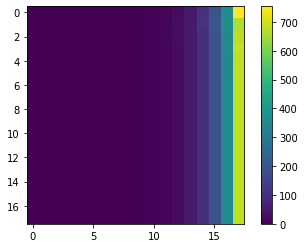

In [ ]:
imshow(np.array(F_ll).T, vmin = 0)
colorbar()

In [ ]:
# Modes x Parameters

reconstructed_bft = np.array([i for i in reconstructed_bf])
b_p = [np.median(reconstructed_bft[:,0]),np.median(reconstructed_bft[:,1])]

np.save("fid_reconstructed_bft", reconstructed_bft)
np.save("fid_b_p", b_p)

F_lp = np.array([(reconstructed_bft[i]-b_p)/(pk_c[i]*2) for i in range(0,N)])

In [ ]:
# parameters x modes...

F_pl = [(np.array(reconstructed_pk_1[1]- b_l)/pkr_ic0[1])/delta,(np.array(reconstructed_pk_2[1]- b_l)/pkr_ic0[1])/delta,]

F_pp = [(bff_1 - b_p)/delta, (bff_2 - b_p)/delta]

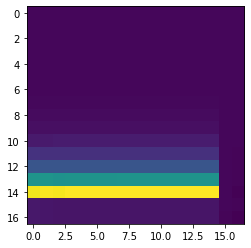

In [ ]:
imshow(np.vstack([np.hstack([F_ll,F_lp]),np.hstack([F_pl,F_pp])]))

In [ ]:
F_tt = np.nan_to_num(np.vstack([np.hstack([F_ll,F_lp]),np.hstack([F_pl,F_pp])]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


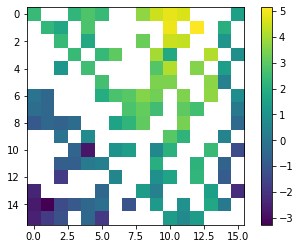

In [ ]:
imshow(np.log10(np.linalg.inv(F_tt[1:,1:].T)))
colorbar()

In [ ]:
1/np.sqrt(np.diag(F_tt))

array([17.930803  ,  9.579134  ,  6.068214  ,  3.8376682 ,  2.4915006 ,
        1.69316   ,  1.1585174 ,  0.80543256,  0.57323086,  0.41408768,
        0.29884517,  0.21459328,  0.15017678,  0.10756895,  0.0785066 ,
        0.0580854 ,  0.04290184,  0.03162035], dtype=float32)

In [ ]:
np.sqrt(np.diag(np.linalg.inv(F_tt[1:,1:].T)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


array([ 1.8531395, 13.473138 , 13.412751 , 19.440733 , 13.614211 ,
       22.083376 , 16.224945 ,        nan, 16.241442 , 13.721054 ,
       34.109955 ,        nan,        nan,        nan], dtype=float32)

In [ ]:
#eq 5.3

#derivatives are equal to zero for initial bandpowers, so only matter for forward model parameters

#inverse FGPA
sim_var = np.exp((np.log(-1*np.log(fins)/b1)/b2))
       
new_gal_1= np.exp(-b1*sim_var**b2)

new_gal_2= np.exp(-(b1+delta)*sim_var**b2)

partial_b1 = (new_gal_2-new_gal_1)/delta
                 
                 
new_gal_1= np.exp(-b1*sim_var**b2)

new_gal_2= np.exp(-(b1)*sim_var**(b2+delta))

partial_b2 = (new_gal_2-new_gal_1)/delta
                 
#eq 5.4

res = data- fins

Gl_1 = np.sum(partial_b1 * res*inv_sigma)
Gl_2 = np.sum(partial_b2 * res*inv_sigma)

In [ ]:
F_tt[-1,-1] += Gl_2
F_tt[-2,-2] += Gl_1

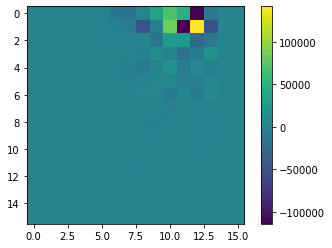

In [ ]:
imshow(np.linalg.inv(F_tt[1:,1:].T))
colorbar()

In [ ]:
err_norm = 1/np.sqrt(np.diag(F_tt))

In [ ]:
err_marg = np.sqrt(np.diag(np.linalg.inv(F_tt[:,:])))
print(err_marg)

[17.319292 16.086893  9.587956 17.52642  13.778857 24.925262       nan
 26.208895 28.508596       nan       nan 11.161844 12.022815       nan
       nan]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [ ]:
for i,_ in enumerate(err_norm):
    print(err_norm[i],err_marg[i])

17.930803 27.07428
9.579134 nan
6.068214 21.888702
3.8376682 nan
2.4915006 nan
1.69316 21.331112
1.1585174 nan
0.80543256 nan
0.57323086 nan
0.41408768 nan
0.29884517 97.41753
0.21459328 nan
0.15017678 28.878393
0.10756895 nan
0.078506604 nan
0.0580854 73.284935
0.042901844 21.672329
0.031620353 4.920523


In [ ]:
np.std(reconstructed_bft[:,0]),np.std(reconstructed_bft[:,1])

(0.0019330401, 0.020245614)

<ErrorbarContainer object of 3 artists>

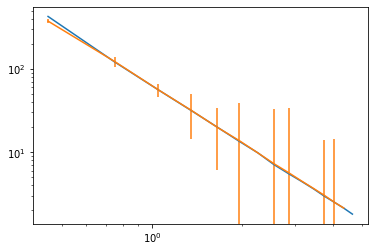

In [ ]:
plt.loglog(pkr_ic0[0], pkr_ic0[1], label = 'initial')

#plt.errorbar(reconstructed_initial_mode_pks[0][0][:-1],reconstructed_initial_mode_pks[0][1][:-1]-b_l[:-1],yerr=err_marg[:-1])
plt.errorbar(reconstructed_initial_mode_pks[0][0][:-1],pk_c[:-1]-b_l[:-1],yerr=err_marg[:-1])
#plt.errorbar(reconstructed_initial_mode_pks[0][0][:-1]*1.03,reconstructed_initial_mode_pks[0][1][:-1]-b_l[:-1],yerr=err_norm[:-3])

#After marginalization... small scale error explode!


In [ ]:
#np.save("lya_err_marg", err_marg)
np.save("fid_initial_pk_x",pkr_ic0[0])
np.save("fid_true_initial_pk_y",pkr_ic0[1])
np.save("fid_reconstructed_initial_pk_x", reconstructed_initial_mode_pks[0][0][:-1])
np.save("fid_reconstructed_initial_pk_y", reconstructed_initial_mode_pks[0][1][:-1]-b_l[:-1])
np.save("fisher_matrix", F_tt)

In [ ]:
#covariance matrix for parameters!
np.linalg.inv(F_tt[:,:].T)[-2:,-2:]

array([[-1.2358124e-03,  2.9410496e-05],
       [ 3.4953275e-05, -4.4728719e-02]], dtype=float32)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test', 'indices']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


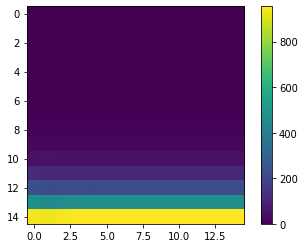

In [ ]:
import numpy
%pylab inline

pk_c = np.load("fid_pk_c-8.npy")
#pkr_ic0_x = np.load("fid_pkr_ic0_x-7.npy")
pkr_ic0_y = np.load("fid_pkr_ic0_y-8.npy")
pks = np.load("fid_pks-8.npy")
reconstructed_initial_mode_pks = np.load("fid_reconstructed_initial_mode_pks-8.npy", allow_pickle=True)


#b_l Eq (4.41)

b_l = pk_c - pkr_ic0_y

#eq (4.21) and 4.46

#delta theta = pk_c[i]*2
N = len(pkr_ic0_y)
delta = 0.05
F_tt = np.array([(np.array(reconstructed_initial_mode_pks[i][1]- b_l)/pkr_ic0_y)/(pk_c[i]*2) for i in range(0,N)])
#F_ll = np.array([(np.array(reconstructed_initial_mode_pks[i][1]- pk_c))/(0.06) for i in range(0,N)])

imshow(F_tt, vmin = 0)
colorbar()

#Parameter Estimation With New Powerspectra

##Helper Functions

In [ ]:
import numpy as np

# reconstructed fiducial powerspectrum
k_vals = pkr_ic0[0]
fid_recon = reconstructed_pk[1]

# Fisher matrix
#F_tt = np.load("fisher_matrix.npy")

err_marg = np.sqrt(np.diag(np.linalg.inv(F_tt[:,:].T)))
y = np.nan_to_num(err_marg, nan=np.inf)

weights = (y)**2
print(weights)

# Inferred Power spectrum model
def true_test_powerspectrum(k, a, n):
    return a*(k**n)

def neg_chi_squared(parameter_guess):
    A_s, n_s = parameter_guess
    #enforcing a flat prior on the parameters, if they are outside of this range
    #the likelihood is negative infinity (forcing the transition prob to zero)
    if A_s<0 or A_s>1000:
        return -np.inf
    if n_s>=0:
        return -np.inf
    try:
        guess = np.zeros(len(k_vals))
        i=0
        for k in k_vals:
          guess[i] = true_test_powerspectrum(k, A_s, n_s)
          i+=1
    
        #chi_squared = (fid_recon - guess).T@np.linalg.inv(F_tt)@(fid_recon - guess)
        chi_squared = ((fid_recon - b_l - guess)**2)/weights #weights diagonal 
        return -np.sum(chi_squared)
    except:
        return -np.inf

15
(15,)
(15, 15)
[299.9579  258.78812  91.92891 307.1754  189.8569  621.26874       inf
 686.9062  812.74005       inf       inf 124.58677 144.54808       inf
       inf]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
#!pip install emcee
import emcee
nwalkers = 200
ndim = 2

#parameters = [0,0]
sampler = emcee.EnsembleSampler(nwalkers, ndim, neg_chi_squared, args=[])

In [ ]:
p0 = [63,-2.3]+np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))/2 #initializing walker starting locations

In [ ]:
pos, prob, state = sampler.run_mcmc(p0, 3000)
#long burnin seems nessisary for some strange reason...

In [ ]:
sampler.reset()
_ = sampler.run_mcmc(pos, 500)

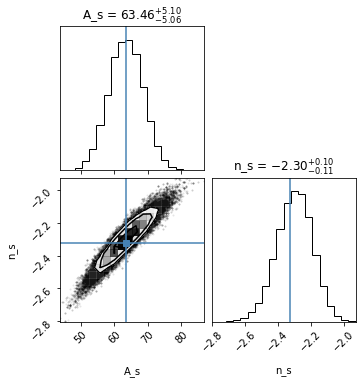

In [ ]:
#Showing sample chain with most likely point...
#!pip install corner
import corner
figure = corner.corner(sampler.flatchain[:],labels=["A_s","n_s"],truths=[63*1.01, -2.3*1.01], show_titles=True)
#figurelike = corner.corner(sampler.flatchain[:],labels=["A_s","n_s"],truths=[70, -2.4], show_titles=True)

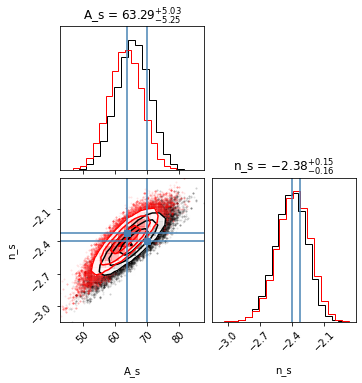

In [ ]:
corner.corner(sampler.flatchain[:],labels=["A_s","n_s"],truths=[63*1.01, -2.3*1.01], show_titles=True, fig= figurelike, color='red')